In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import InputLayer, Dense, Layer
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
class NeuralNet:
    # Initialize the class
    def __init__(self, t_train, x_train, t_test, x_test, layers, t_min, t_max):
        self.t_train = t_train
        self.x_train = x_train
        self.t_test = t_test
        self.x_test = x_test
        self.loss_history = {"train": [], "test": []}
        
        # Initialize NNs with given number of layers and domain bounds [t_min, tmax]
        self.t_min = t_min
        self.t_max = t_max
        self.initialize_nn(layers)
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def initialize_nn(self, layers):        
        """Functions used to establish the initial neural network"""
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32))
            weights.append(W)
            biases.append(b)        
        self.weights = weights
        self.biases = biases
        self.trainable_variables = self.weights + self.biases
       
    def net(self, X):
        H = 2.0 * (X - self.t_min) / (self.t_max - self.t_min) - 1.0
        for l in range(0, len(self.weights) - 1):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    @tf.function
    def loss_train(self):
        x_pred = self.net(self.t_train)
        loss = tf.reduce_mean(tf.square(self.x_train - x_pred)) * 10
        return loss
    
    @tf.function
    def loss_test(self):
        x_pred = self.net(self.t_test)
        loss = tf.reduce_mean(tf.square(self.x_test - x_pred)) * 10
        return loss

    def get_test_error(self):
        x_pred = self.net(self.t_test)
        error_x = tf.norm(self.x_test - x_pred, 2) / tf.norm(self.x_test, 2)
        return error_x
    
    def train(self, nIter: int, learning_rate: float, idxOpt: int):
        """Function used for training the model"""
        if idxOpt == 1:
            # mode 1: running the Gradient Descent optimization
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif idxOpt == 2:
            # mode 2: running the Adam optimization
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported idxOpt")

        varlist = self.trainable_variables
        start_time = time.time()

        for it in range(nIter):
            self.optimizer.minimize(self.loss_train, varlist)
            
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_train = self.loss_train().numpy()
                loss_test = self.loss_test().numpy()
                self.loss_history["train"].append(loss_train)
                self.loss_history["test"].append(loss_test)
                print('It: %d, Train Loss: %.3e, Test Loss: %.3e, Time: %.2f' % 
                      (it, loss_train, loss_test, elapsed))
                start_time = time.time()

In [3]:
# Create data points and get random split of train, test data sets by index slicing
n_total = 1000
train_ratio = 0.8
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = x = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()                
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

It: 0, Train Loss: 5.107e+00, Test Loss: 4.923e+00, Time: 0.83
It: 100, Train Loss: 5.052e+00, Test Loss: 4.819e+00, Time: 0.54
It: 200, Train Loss: 5.047e+00, Test Loss: 4.815e+00, Time: 0.53
It: 300, Train Loss: 5.036e+00, Test Loss: 4.806e+00, Time: 0.60
It: 400, Train Loss: 4.874e+00, Test Loss: 4.662e+00, Time: 0.54
It: 500, Train Loss: 2.590e-03, Test Loss: 2.741e-03, Time: 0.54
It: 600, Train Loss: 2.454e-03, Test Loss: 2.432e-03, Time: 0.54
It: 700, Train Loss: 2.402e-03, Test Loss: 2.381e-03, Time: 0.55
It: 800, Train Loss: 2.354e-03, Test Loss: 2.334e-03, Time: 0.59
It: 900, Train Loss: 2.307e-03, Test Loss: 2.288e-03, Time: 0.60
It: 1000, Train Loss: 2.263e-03, Test Loss: 2.245e-03, Time: 0.55
It: 1100, Train Loss: 2.221e-03, Test Loss: 2.203e-03, Time: 0.53
It: 1200, Train Loss: 2.180e-03, Test Loss: 2.164e-03, Time: 0.51
It: 1300, Train Loss: 2.142e-03, Test Loss: 2.126e-03, Time: 0.53
It: 1400, Train Loss: 2.105e-03, Test Loss: 2.090e-03, Time: 0.53
It: 1500, Train Loss: 

Text(0.02, 0.9, 'Gradient Descent Optimization')

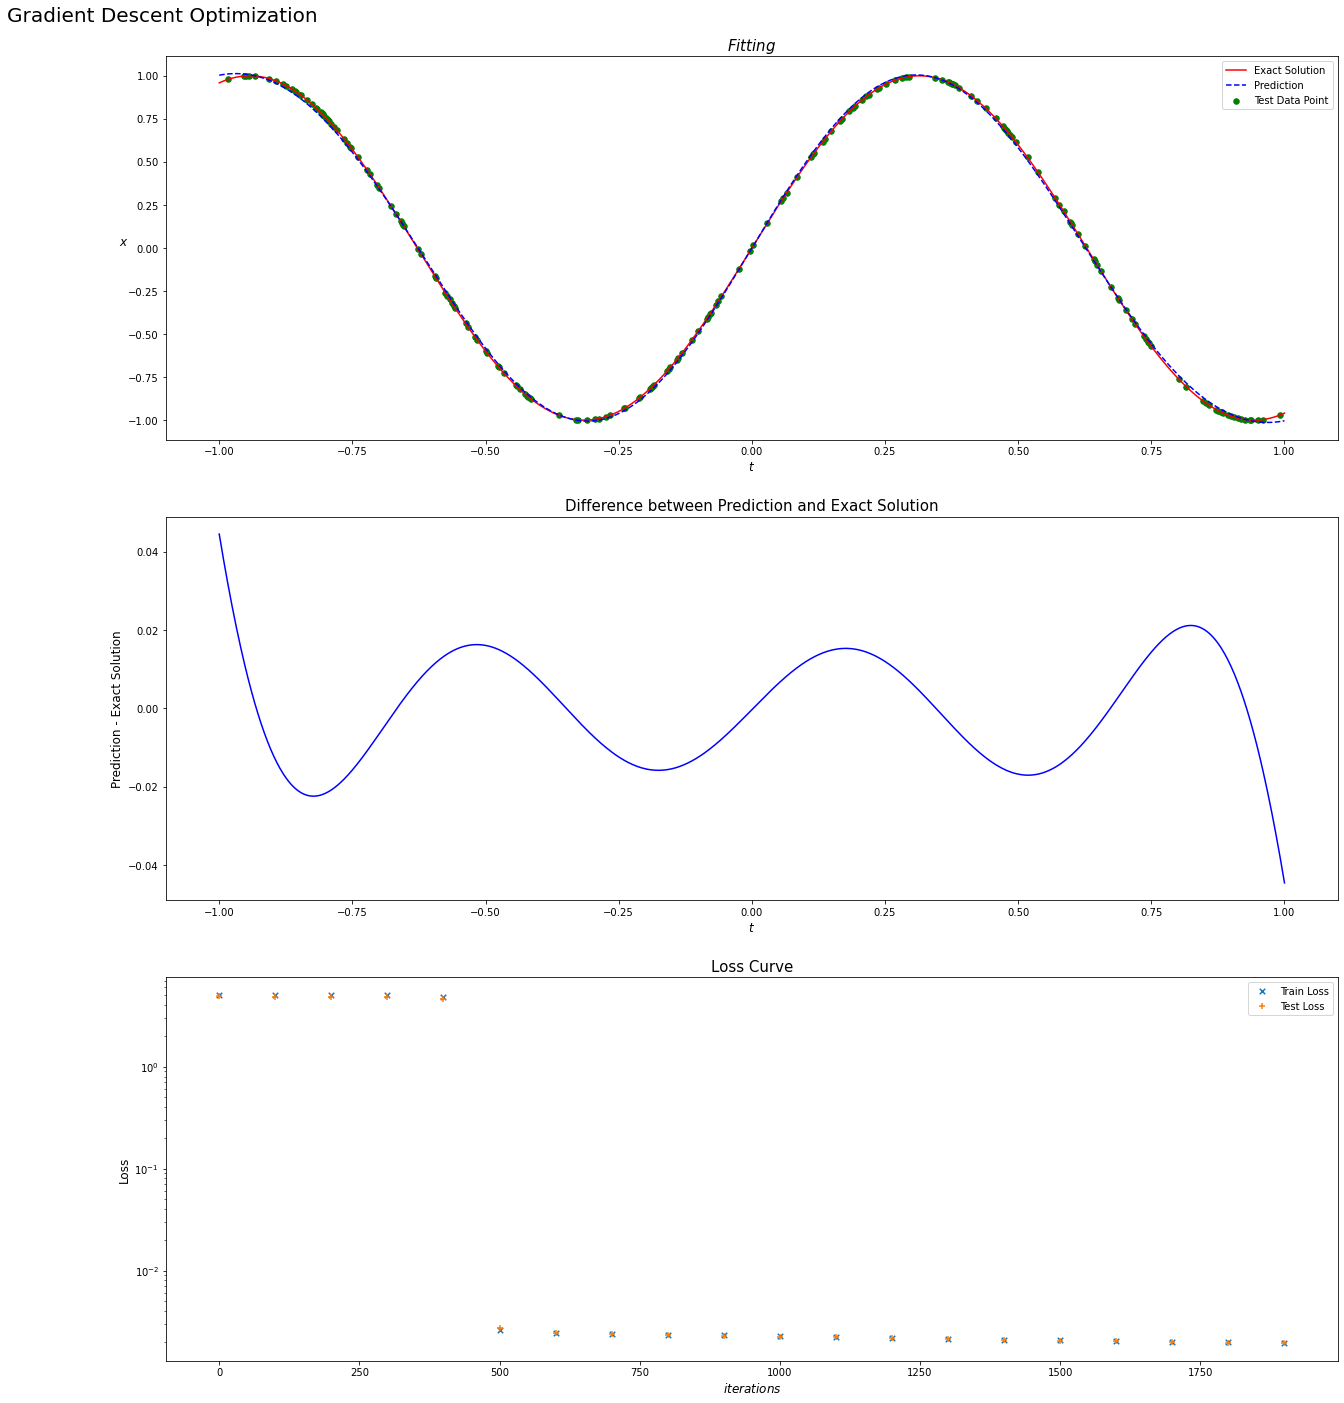

In [6]:
%matplotlib inline

######################################################################
############################# Plotting ###############################
######################################################################    
fig = plt.figure(figsize=(21, 24))

ax = plt.subplot(311)
ax.plot(t_all, x_all, "r", label="Exact Solution")
ax.plot(t_all, pred_all, "b--", label="Prediction")
ax.scatter(t_test, x_test, s=30, c="g", label="Test Data Point")
ax.legend()
ax.set_xlabel("$t$", fontsize = 12)
ax.set_ylabel("$x$", fontsize = 12, rotation = 0)
ax.set_title("$Fitting$", fontsize = 15)

ax = plt.subplot(312)
ax.plot(t_all, pred_all - x_all, "b-")
ax.set_xlabel("$t$", fontsize = 12)
ax.set_ylabel("Prediction - Exact Solution", fontsize = 12, rotation = 90)
ax.set_title("Difference between Prediction and Exact Solution", fontsize = 15)

ax = plt.subplot(313)
loss_train = np.array(model.loss_history["train"])
loss_test = np.array(model.loss_history["test"])
ax.scatter(np.arange(loss_train.size) * 100, loss_train, s=30, marker="x", label="Train Loss")
ax.scatter(np.arange(loss_train.size) * 100, loss_test, s=30, marker="+", label="Test Loss")
ax.legend()
ax.set_xlabel("$iterations$", fontsize = 12)
ax.set_ylabel("Loss", fontsize = 12, rotation = 90)
ax.set_yscale("log")
ax.set_title('Loss Curve', fontsize = 15)

plt.gcf().text(0.02, 0.9, "Gradient Descent Optimization", fontsize=20)

In [7]:
# Create data points and get random split of train, test data sets by index slicing
n_total = 1000
train_ratio = 0.8
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = x = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()                
model.train(2000, learning_rate=0.001, idxOpt=2)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

It: 0, Train Loss: 5.135e+00, Test Loss: 5.316e+00, Time: 0.18
It: 100, Train Loss: 4.963e+00, Test Loss: 5.168e+00, Time: 0.67
It: 200, Train Loss: 4.957e+00, Test Loss: 5.161e+00, Time: 0.81
It: 300, Train Loss: 3.292e-01, Test Loss: 3.313e-01, Time: 0.70
It: 400, Train Loss: 2.169e-02, Test Loss: 2.198e-02, Time: 0.70
It: 500, Train Loss: 1.384e-02, Test Loss: 1.406e-02, Time: 0.83
It: 600, Train Loss: 9.748e-03, Test Loss: 9.909e-03, Time: 0.67
It: 700, Train Loss: 7.378e-03, Test Loss: 7.497e-03, Time: 0.67
It: 800, Train Loss: 5.821e-03, Test Loss: 5.923e-03, Time: 0.82
It: 900, Train Loss: 4.764e-03, Test Loss: 4.835e-03, Time: 0.77
It: 1000, Train Loss: 3.936e-03, Test Loss: 4.009e-03, Time: 0.68
It: 1100, Train Loss: 3.332e-03, Test Loss: 3.393e-03, Time: 0.68
It: 1200, Train Loss: 2.863e-03, Test Loss: 2.918e-03, Time: 0.67
It: 1300, Train Loss: 2.501e-03, Test Loss: 2.556e-03, Time: 0.66
It: 1400, Train Loss: 4.288e-03, Test Loss: 4.400e-03, Time: 0.88
It: 1500, Train Loss: 

Text(0.02, 0.9, 'Adam Optimization')

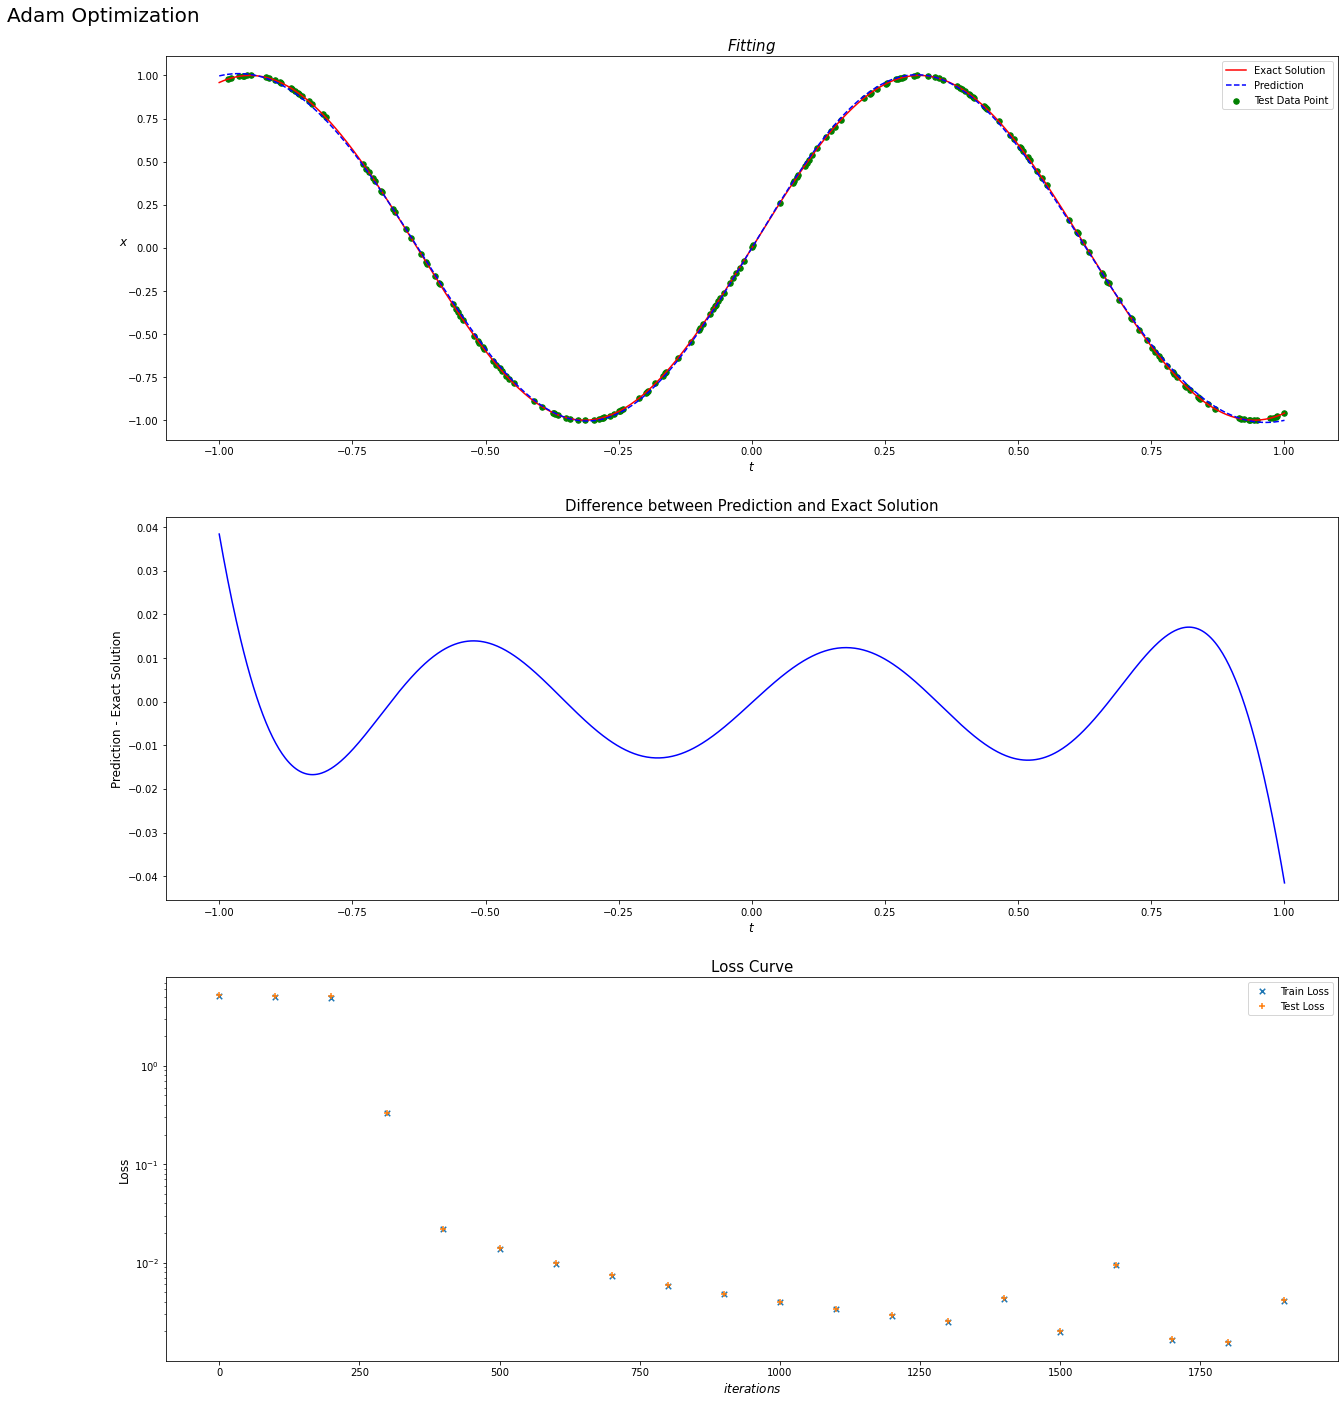

In [9]:
%matplotlib inline

######################################################################
############################# Plotting ###############################
######################################################################    
fig = plt.figure(figsize=(21, 24))

ax = plt.subplot(311)
ax.plot(t_all, x_all, "r", label="Exact Solution")
ax.plot(t_all, pred_all, "b--", label="Prediction")
ax.scatter(t_test, x_test, s=30, c="g", label="Test Data Point")
ax.legend()
ax.set_xlabel("$t$", fontsize = 12)
ax.set_ylabel("$x$", fontsize = 12, rotation = 0)
ax.set_title("$Fitting$", fontsize = 15)

ax = plt.subplot(312)
ax.plot(t_all, pred_all - x_all, "b-")
ax.set_xlabel("$t$", fontsize = 12)
ax.set_ylabel("Prediction - Exact Solution", fontsize = 12, rotation = 90)
ax.set_title("Difference between Prediction and Exact Solution", fontsize = 15)

ax = plt.subplot(313)
loss_train = np.array(model.loss_history["train"])
loss_test = np.array(model.loss_history["test"])
ax.scatter(np.arange(loss_train.size) * 100, loss_train, s=30, marker="x", label="Train Loss")
ax.scatter(np.arange(loss_train.size) * 100, loss_test, s=30, marker="+", label="Test Loss")
ax.legend()
ax.set_xlabel("$iterations$", fontsize = 12)
ax.set_ylabel("Loss", fontsize = 12, rotation = 90)
ax.set_yscale("log")
ax.set_title('Loss Curve', fontsize = 15)

plt.gcf().text(0.02, 0.9, "Adam Optimization", fontsize=20)